<a href="https://colab.research.google.com/github/MyeongGuJo/hayaku-250322/blob/main/hayaku_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hands-on Diffusion Model in HAYAKU Conference**

**MyeongGu Jo (HAI presenter @ Hanyang University)**

## Diffusion Model Example: **Denoising Diffusion Probabilistic Model (DDPM; Ho et al., 2020)**

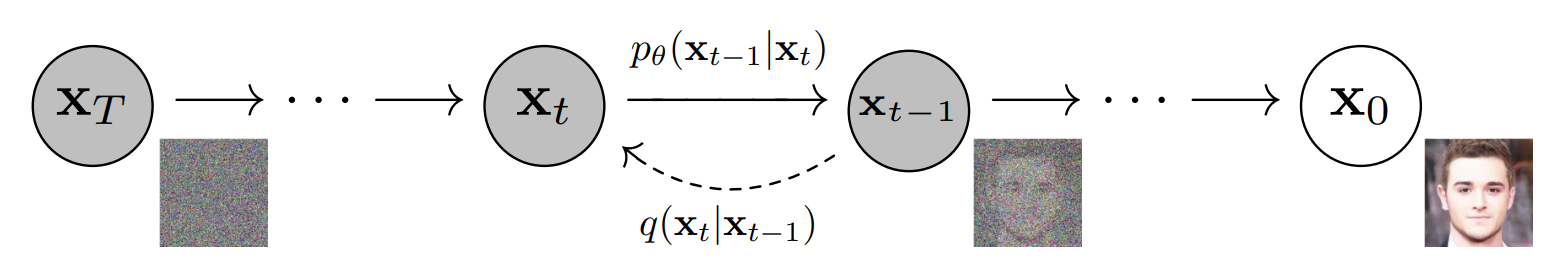

Diffusion Models are a class of generative models that have been widely adopted in various fields, including:

- **Image Generation** (e.g., DALL·E, Stable Diffusion)
- **Audio Synthesis** (e.g., speech generation, music composition)
- **Molecular Design** (e.g., drug discovery, protein structure prediction)

### 🔹 Why Diffusion Models?
Diffusion Models excel in generating high-quality and diverse samples by **iteratively denoising noisy data**. Unlike GANs, which often suffer from mode collapse, diffusion models offer **stable training** and **better sample diversity** through their probabilistic formulation.

### 🔹 What This Code Demonstrates
In this example, we apply a **diffusion model to a 2D dataset** to visualize and understand:
1. How data gradually **diffuses into noise** over multiple timesteps.
2. How the model **reverses this process** to reconstruct structured data.
3. The fundamental principles of **diffusion-based generative modeling** before extending it to more complex domains like images and 3D structures.

By running this code, you'll gain **intuitive insights** into how diffusion models work and why they are revolutionizing generative modeling.


# Thanks to

**Yejun Kwon (HAI OB @Hanyang University)**

## Table of Contents
- Dataset
- Diffusion
- Model
- Training
- Sampling


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms

In [2]:
'''
Synthetic distributions from https://github.com/nicola-decao/BNAF/
'''
def sample2d(data, batch_size=200, scale_factor=1.):
    rng = np.random.RandomState()

    if data == '8gaussians':
        scale = 4.
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                         1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        for i in range(batch_size):
            point = rng.randn(2) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype='float32')
        dataset /= 1.414
        dataset *= scale_factor
        return dataset

    elif data == '2spirals':
        n = np.sqrt(np.random.rand(batch_size // 2, 1)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        d1y = np.sin(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
        x += np.random.randn(*x.shape) * 0.1
        x *= scale_factor
        return x

    elif data == 'checkerboard':
        x1 = np.random.rand(batch_size) * 4 - 2
        x2_ = np.random.rand(batch_size) - np.random.randint(0, 2, batch_size) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        dataset = np.concatenate([x1[:, None], x2[:, None]], 1) * 2
        dataset *= scale_factor
        return dataset

    else:
        raise RuntimeError

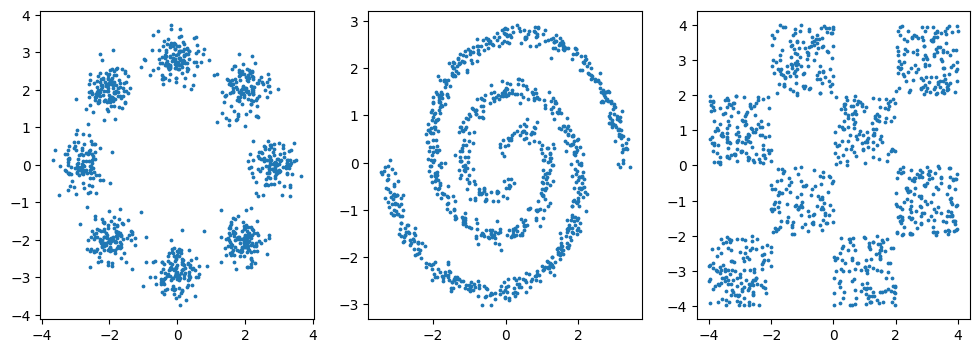

In [3]:
'''visualize datasets'''
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
x = torch.tensor(sample2d('8gaussians', batch_size=1000, scale_factor=1.))
axs[0].scatter(x[:,0], x[:,1], s=3)
x = torch.tensor(sample2d('2spirals', batch_size=1000, scale_factor=1.))
axs[1].scatter(x[:,0], x[:,1], s=3)
x = torch.tensor(sample2d('checkerboard', batch_size=1000, scale_factor=1.))
axs[2].scatter(x[:,0], x[:,1], s=3)

In [4]:
dataset_name = '8gaussians'
bs = 64
n_data = 10000

data_np = sample2d(dataset_name, batch_size=n_data, scale_factor=1.)
data_tensor = torch.tensor(data_np)
train_dataset = TensorDataset(data_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)

# Diffusion

Add noise to data with time-step t (0, 1, 2, ... , t_step-1)

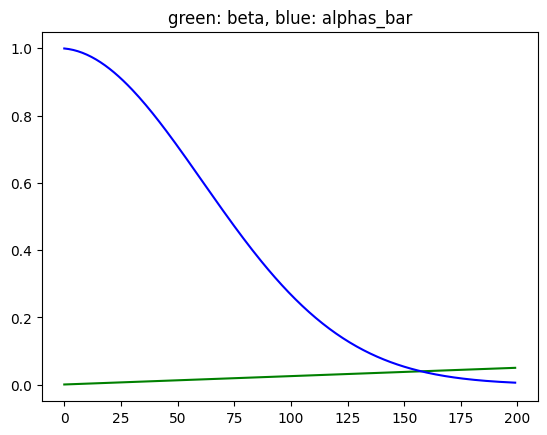

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

n_step = 200
beta_start = 0.0001
beta_end = 0.01
scale = 1000 / n_step # T = 1000 ->. scale = 1

betas = torch.linspace(beta_start * scale, beta_end * scale, n_step)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

plt.plot(betas, 'g')
plt.plot(alphas_bar, 'b')
plt.title('green: beta, blue: alphas_bar')
plt.show()

alphas_bar = alphas_bar.to(device)
betas = betas.to(device)
alphas = alphas.to(device)

In [6]:
def extract(arr, t, x_shape):
    if not torch.is_tensor(t):
        b = 1
        t = torch.tensor(t).to(device)
    else:
        b = t.shape[0]

    out = arr.gather(-1, t) # array의 t번째 index를 가져와서 새로운 tensor로 만들어줌
    return out.view((b, ) + (1, ) * (len(x_shape) - 1))

def diffuse_once(x, t):
    return (1 - betas[t]).sqrt() * x + betas[t].sqrt() * torch.randn_like(x)

def diffuse(x, t, eta=None):
    if eta is None:
        eta = torch.randn_like(x).to(device)

    x_t = extract(alphas_bar.sqrt(), t, x.shape) * x + extract((1 - alphas_bar).sqrt(), t, x.shape) * eta

    return x_t

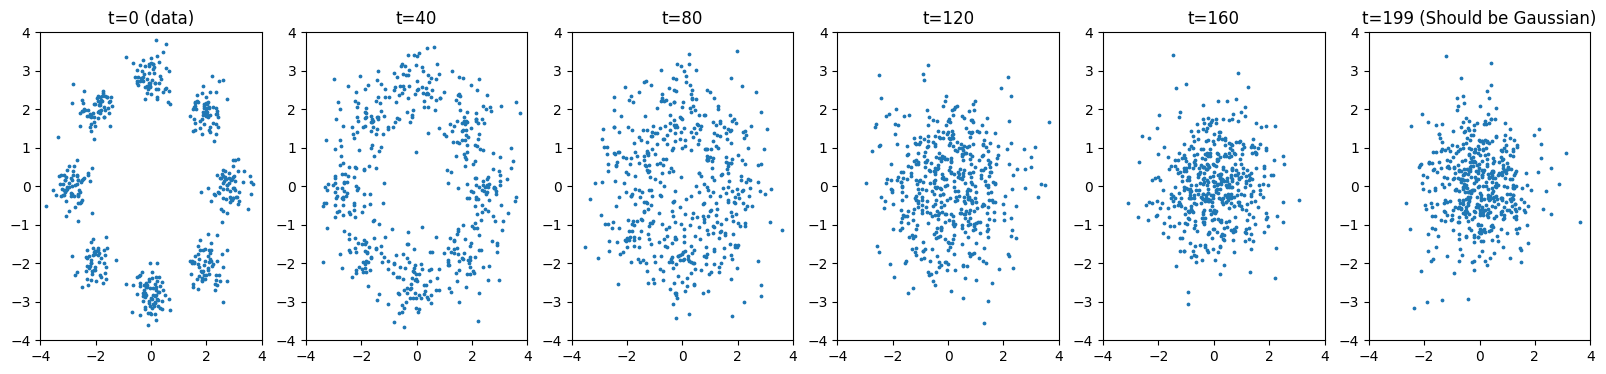

In [7]:
'''visualize diffusion process'''
n_plot = 5
x = torch.tensor(sample2d(dataset_name, batch_size=500)).to(device)

fig, axs = plt.subplots(ncols=n_plot+1, figsize=(20, 4))

for i_plot in range(n_plot):
    t = (n_step // n_plot) * i_plot
    x_diffused = diffuse(x, t).to('cpu')
    axs[i_plot].scatter(x_diffused[:,0], x_diffused[:,1], s=3)
    if i_plot == 0:
        axs[0].set_title('t=0 (data)')
    else:
        axs[i_plot].set_title(f't={t}')
    axs[i_plot].set_xlim([-4,4])
    axs[i_plot].set_ylim([-4,4])

x_diffused = diffuse(x, n_step-1).to('cpu')
axs[n_plot].scatter(x_diffused[:,0], x_diffused[:,1], s=3)
axs[n_plot].set_title(f't={n_step-1} (Should be Gaussian)')
axs[n_plot].set_xlim([-4,4])
axs[n_plot].set_ylim([-4,4])

plt.show()

# MultiLayerPerceptron (MLP)

**Timestep embedding** is important.


In [8]:
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal timestep embeddings (Transformer-style).
    Args:
        timesteps: A 1D tensor of shape [batch_size] representing timesteps.
        embedding_dim: The dimension of the embedding.
    Returns:
        A tensor of shape [batch_size, embedding_dim] containing sinusoidal embeddings.
    """
    half_dim = embedding_dim // 2
    emb_scale = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb_scale)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

In [9]:
class MLP(nn.Module):
    """
    MLP with time embeddings and configurable hidden layer structure, without residual connections.

    Args:
        input_dim: Dimension of the input vector (e.g., 2 for 2D data).
        dims: A list of hidden dimensions, e.g., [64, 128, 256, 128, 64].
              The network will use these dimensions for its hidden layers.
        output_dim: Dimension of the output vector (e.g., 2 for noise prediction).
        t_emb_dim: Dimension of the time embedding.
    """
    def __init__(self, input_dim, dims, output_dim, t_emb_dim=128):
        super().__init__()
        self.t_emb_dim = t_emb_dim

        # Process the sinusoidal time embeddings
        self.time_embed = nn.Sequential(
            nn.Linear(t_emb_dim, t_emb_dim),
            nn.ReLU(),
            nn.Linear(t_emb_dim, t_emb_dim)
        )

        # Input layer: maps concatenated (x, time embedding) to the first hidden dimension
        self.fc_in = nn.Linear(input_dim + t_emb_dim, dims[0])

        # Hidden layers without residual connections
        hidden_layers = []
        for i in range(len(dims) - 1):
            hidden_layers.append(nn.Linear(dims[i], dims[i+1]))
            hidden_layers.append(nn.ReLU())
        self.hidden_layers = nn.Sequential(*hidden_layers)

        # Output layer: maps the last hidden dimension to the output dimension
        self.fc_out = nn.Linear(dims[-1], output_dim)

    def forward(self, x, t):
        """
        Forward pass:
        Args:
            x: A tensor of shape [batch_size, input_dim].
            t: A tensor of shape [batch_size] representing timesteps.
        Returns:
            A tensor of shape [batch_size, output_dim].
        """
        # Generate and process time embeddings
        t_emb = get_timestep_embedding(t, self.t_emb_dim)
        t_emb = self.time_embed(t_emb)

        # Concatenate the input and time embeddings
        x_in = torch.cat([x, t_emb], dim=1)

        # Input layer
        x = F.relu(self.fc_in(x_in))
        # Hidden layers
        x = self.hidden_layers(x)
        # Final output layer
        x = self.fc_out(x)
        return x


In [11]:
lr = 3e-4
num_epochs = 80
dims = [32, 64, 128, 128, 64, 32]

model = MLP(
    input_dim=2,
    dims=dims,
    output_dim=2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

print("model parameter size :", sum(p.numel() for p in model.parameters() if p.requires_grad))

model parameter size : 137730


# DDPM

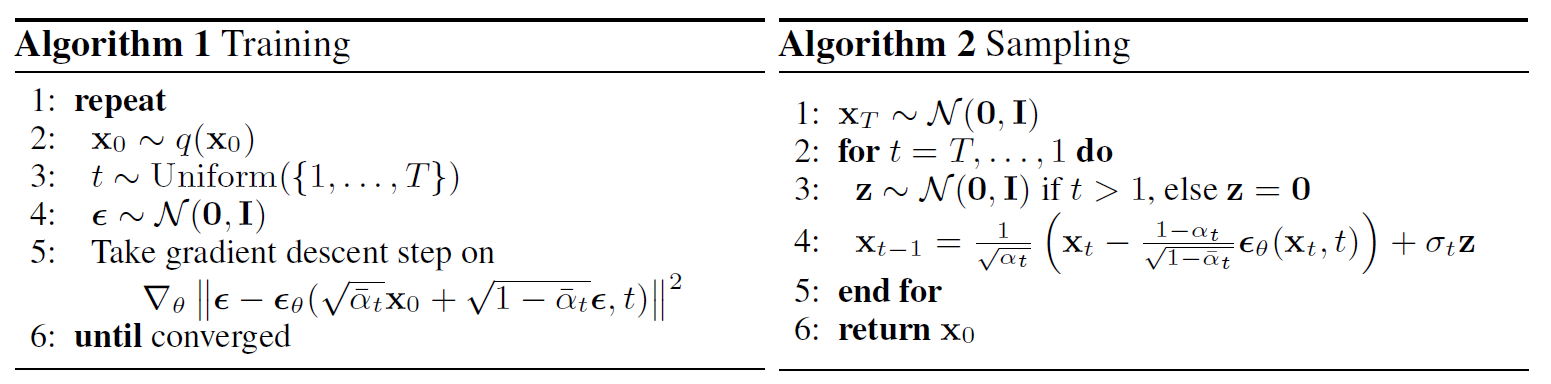

In [12]:
# training
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in progress_bar:
        x = batch[0].to(device)  # shape: [bs, 2]
        optimizer.zero_grad()

        # Sample random timesteps for each example in the batch
        t = torch.randint(0, n_step, (x.size(0),), device=device).long()
        # Sample noise (epsilon) for the diffusion process
        noise = torch.randn_like(x).to(device)
        # Get the noisy version x_t according to the forward process
        x_t = diffuse(x, t, eta=noise)

        # Predict the noise from the noisy data
        noise_pred = model(x_t, t)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)

        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/80: 100%|██████████| 157/157 [00:03<00:00, 47.35it/s, loss=0.5480]


Epoch 1/80, Loss: 0.8213


Epoch 2/80: 100%|██████████| 157/157 [00:01<00:00, 90.79it/s, loss=0.2984] 


Epoch 2/80, Loss: 0.5843


Epoch 3/80: 100%|██████████| 157/157 [00:01<00:00, 120.55it/s, loss=0.1514]


Epoch 3/80, Loss: 0.5482


Epoch 4/80: 100%|██████████| 157/157 [00:01<00:00, 109.55it/s, loss=0.6054]


Epoch 4/80, Loss: 0.5107


Epoch 5/80: 100%|██████████| 157/157 [00:01<00:00, 142.86it/s, loss=0.5550]


Epoch 5/80, Loss: 0.5047


Epoch 6/80: 100%|██████████| 157/157 [00:01<00:00, 142.40it/s, loss=0.4219]


Epoch 6/80, Loss: 0.5084


Epoch 7/80: 100%|██████████| 157/157 [00:01<00:00, 145.99it/s, loss=0.5313]


Epoch 7/80, Loss: 0.4934


Epoch 8/80: 100%|██████████| 157/157 [00:01<00:00, 145.30it/s, loss=0.3204]


Epoch 8/80, Loss: 0.5006


Epoch 9/80: 100%|██████████| 157/157 [00:01<00:00, 145.11it/s, loss=0.4318]


Epoch 9/80, Loss: 0.4907


Epoch 10/80: 100%|██████████| 157/157 [00:01<00:00, 145.85it/s, loss=0.3380]


Epoch 10/80, Loss: 0.4821


Epoch 11/80: 100%|██████████| 157/157 [00:01<00:00, 143.62it/s, loss=0.6733]


Epoch 11/80, Loss: 0.4847


Epoch 12/80: 100%|██████████| 157/157 [00:01<00:00, 142.74it/s, loss=0.4292]


Epoch 12/80, Loss: 0.4718


Epoch 13/80: 100%|██████████| 157/157 [00:01<00:00, 142.93it/s, loss=0.3888]


Epoch 13/80, Loss: 0.4809


Epoch 14/80: 100%|██████████| 157/157 [00:01<00:00, 111.63it/s, loss=0.7576]


Epoch 14/80, Loss: 0.4853


Epoch 15/80: 100%|██████████| 157/157 [00:01<00:00, 115.22it/s, loss=0.2590]


Epoch 15/80, Loss: 0.4856


Epoch 16/80: 100%|██████████| 157/157 [00:01<00:00, 147.09it/s, loss=0.4963]


Epoch 16/80, Loss: 0.4901


Epoch 17/80: 100%|██████████| 157/157 [00:01<00:00, 143.46it/s, loss=0.4499]


Epoch 17/80, Loss: 0.4828


Epoch 18/80: 100%|██████████| 157/157 [00:01<00:00, 139.15it/s, loss=0.3509]


Epoch 18/80, Loss: 0.4660


Epoch 19/80: 100%|██████████| 157/157 [00:01<00:00, 138.28it/s, loss=0.5584]


Epoch 19/80, Loss: 0.4684


Epoch 20/80: 100%|██████████| 157/157 [00:01<00:00, 140.05it/s, loss=0.9668]


Epoch 20/80, Loss: 0.4777


Epoch 21/80: 100%|██████████| 157/157 [00:01<00:00, 142.07it/s, loss=0.5771]


Epoch 21/80, Loss: 0.4675


Epoch 22/80: 100%|██████████| 157/157 [00:01<00:00, 141.93it/s, loss=0.6799]


Epoch 22/80, Loss: 0.4769


Epoch 23/80: 100%|██████████| 157/157 [00:01<00:00, 141.80it/s, loss=0.5483]


Epoch 23/80, Loss: 0.4642


Epoch 24/80: 100%|██████████| 157/157 [00:01<00:00, 137.92it/s, loss=0.6722]


Epoch 24/80, Loss: 0.4658


Epoch 25/80: 100%|██████████| 157/157 [00:01<00:00, 117.60it/s, loss=0.4227]


Epoch 25/80, Loss: 0.4804


Epoch 26/80: 100%|██████████| 157/157 [00:01<00:00, 116.15it/s, loss=0.6150]


Epoch 26/80, Loss: 0.4711


Epoch 27/80: 100%|██████████| 157/157 [00:01<00:00, 139.10it/s, loss=0.3120]


Epoch 27/80, Loss: 0.4753


Epoch 28/80: 100%|██████████| 157/157 [00:01<00:00, 144.02it/s, loss=0.6206]


Epoch 28/80, Loss: 0.4739


Epoch 29/80: 100%|██████████| 157/157 [00:01<00:00, 141.55it/s, loss=0.3693]


Epoch 29/80, Loss: 0.4712


Epoch 30/80: 100%|██████████| 157/157 [00:01<00:00, 144.69it/s, loss=0.3586]


Epoch 30/80, Loss: 0.4649


Epoch 31/80: 100%|██████████| 157/157 [00:01<00:00, 138.54it/s, loss=0.6141]


Epoch 31/80, Loss: 0.4792


Epoch 32/80: 100%|██████████| 157/157 [00:01<00:00, 131.42it/s, loss=0.4385]


Epoch 32/80, Loss: 0.4718


Epoch 33/80: 100%|██████████| 157/157 [00:01<00:00, 140.06it/s, loss=0.3007]


Epoch 33/80, Loss: 0.4749


Epoch 34/80: 100%|██████████| 157/157 [00:01<00:00, 141.86it/s, loss=0.1868]


Epoch 34/80, Loss: 0.4575


Epoch 35/80: 100%|██████████| 157/157 [00:01<00:00, 127.84it/s, loss=0.5677]


Epoch 35/80, Loss: 0.4643


Epoch 36/80: 100%|██████████| 157/157 [00:01<00:00, 113.38it/s, loss=0.2958]


Epoch 36/80, Loss: 0.4604


Epoch 37/80: 100%|██████████| 157/157 [00:01<00:00, 120.66it/s, loss=0.4184]


Epoch 37/80, Loss: 0.4776


Epoch 38/80: 100%|██████████| 157/157 [00:01<00:00, 137.27it/s, loss=0.5090]


Epoch 38/80, Loss: 0.4685


Epoch 39/80: 100%|██████████| 157/157 [00:01<00:00, 136.17it/s, loss=0.5183]


Epoch 39/80, Loss: 0.4635


Epoch 40/80: 100%|██████████| 157/157 [00:01<00:00, 138.07it/s, loss=0.3884]


Epoch 40/80, Loss: 0.4637


Epoch 41/80: 100%|██████████| 157/157 [00:01<00:00, 140.46it/s, loss=0.4227]


Epoch 41/80, Loss: 0.4548


Epoch 42/80: 100%|██████████| 157/157 [00:01<00:00, 136.96it/s, loss=0.5334]


Epoch 42/80, Loss: 0.4589


Epoch 43/80: 100%|██████████| 157/157 [00:01<00:00, 134.20it/s, loss=0.5448]


Epoch 43/80, Loss: 0.4594


Epoch 44/80: 100%|██████████| 157/157 [00:01<00:00, 139.35it/s, loss=0.4230]


Epoch 44/80, Loss: 0.4479


Epoch 45/80: 100%|██████████| 157/157 [00:01<00:00, 139.26it/s, loss=0.6446]


Epoch 45/80, Loss: 0.4596


Epoch 46/80: 100%|██████████| 157/157 [00:01<00:00, 118.71it/s, loss=0.6585]


Epoch 46/80, Loss: 0.4658


Epoch 47/80: 100%|██████████| 157/157 [00:01<00:00, 105.72it/s, loss=0.4463]


Epoch 47/80, Loss: 0.4703


Epoch 48/80: 100%|██████████| 157/157 [00:01<00:00, 137.56it/s, loss=0.3672]


Epoch 48/80, Loss: 0.4539


Epoch 49/80: 100%|██████████| 157/157 [00:01<00:00, 139.28it/s, loss=0.4271]


Epoch 49/80, Loss: 0.4625


Epoch 50/80: 100%|██████████| 157/157 [00:01<00:00, 138.95it/s, loss=0.6390]


Epoch 50/80, Loss: 0.4766


Epoch 51/80: 100%|██████████| 157/157 [00:01<00:00, 140.47it/s, loss=0.4199]


Epoch 51/80, Loss: 0.4640


Epoch 52/80: 100%|██████████| 157/157 [00:01<00:00, 132.77it/s, loss=0.3549]


Epoch 52/80, Loss: 0.4594


Epoch 53/80: 100%|██████████| 157/157 [00:01<00:00, 136.93it/s, loss=0.3650]


Epoch 53/80, Loss: 0.4574


Epoch 54/80: 100%|██████████| 157/157 [00:01<00:00, 138.68it/s, loss=0.4601]


Epoch 54/80, Loss: 0.4581


Epoch 55/80: 100%|██████████| 157/157 [00:01<00:00, 136.27it/s, loss=0.5215]


Epoch 55/80, Loss: 0.4534


Epoch 56/80: 100%|██████████| 157/157 [00:01<00:00, 127.06it/s, loss=0.5460]


Epoch 56/80, Loss: 0.4536


Epoch 57/80: 100%|██████████| 157/157 [00:01<00:00, 117.19it/s, loss=0.4718]


Epoch 57/80, Loss: 0.4710


Epoch 58/80: 100%|██████████| 157/157 [00:01<00:00, 110.65it/s, loss=0.2348]


Epoch 58/80, Loss: 0.4538


Epoch 59/80: 100%|██████████| 157/157 [00:01<00:00, 138.15it/s, loss=0.2351]


Epoch 59/80, Loss: 0.4434


Epoch 60/80: 100%|██████████| 157/157 [00:01<00:00, 138.80it/s, loss=0.8764]


Epoch 60/80, Loss: 0.4486


Epoch 61/80: 100%|██████████| 157/157 [00:01<00:00, 139.78it/s, loss=0.5001]


Epoch 61/80, Loss: 0.4645


Epoch 62/80: 100%|██████████| 157/157 [00:01<00:00, 136.36it/s, loss=0.7609]


Epoch 62/80, Loss: 0.4511


Epoch 63/80: 100%|██████████| 157/157 [00:01<00:00, 133.25it/s, loss=0.7292]


Epoch 63/80, Loss: 0.4588


Epoch 64/80: 100%|██████████| 157/157 [00:01<00:00, 113.75it/s, loss=0.4943]


Epoch 64/80, Loss: 0.4573


Epoch 65/80: 100%|██████████| 157/157 [00:01<00:00, 98.62it/s, loss=0.4853]


Epoch 65/80, Loss: 0.4528


Epoch 66/80: 100%|██████████| 157/157 [00:01<00:00, 131.11it/s, loss=0.3415]


Epoch 66/80, Loss: 0.4473


Epoch 67/80: 100%|██████████| 157/157 [00:01<00:00, 117.04it/s, loss=0.8558]


Epoch 67/80, Loss: 0.4643


Epoch 68/80: 100%|██████████| 157/157 [00:01<00:00, 108.88it/s, loss=0.4706]


Epoch 68/80, Loss: 0.4478


Epoch 69/80: 100%|██████████| 157/157 [00:01<00:00, 134.31it/s, loss=0.8188]


Epoch 69/80, Loss: 0.4593


Epoch 70/80: 100%|██████████| 157/157 [00:01<00:00, 137.46it/s, loss=0.2890]


Epoch 70/80, Loss: 0.4693


Epoch 71/80: 100%|██████████| 157/157 [00:01<00:00, 135.07it/s, loss=0.5212]


Epoch 71/80, Loss: 0.4574


Epoch 72/80: 100%|██████████| 157/157 [00:01<00:00, 138.55it/s, loss=0.5419]


Epoch 72/80, Loss: 0.4444


Epoch 73/80: 100%|██████████| 157/157 [00:01<00:00, 133.67it/s, loss=0.3190]


Epoch 73/80, Loss: 0.4541


Epoch 74/80: 100%|██████████| 157/157 [00:01<00:00, 132.25it/s, loss=0.5069]


Epoch 74/80, Loss: 0.4650


Epoch 75/80: 100%|██████████| 157/157 [00:01<00:00, 135.97it/s, loss=0.4409]


Epoch 75/80, Loss: 0.4654


Epoch 76/80: 100%|██████████| 157/157 [00:01<00:00, 136.26it/s, loss=0.6503]


Epoch 76/80, Loss: 0.4753


Epoch 77/80: 100%|██████████| 157/157 [00:01<00:00, 116.09it/s, loss=0.5049]


Epoch 77/80, Loss: 0.4524


Epoch 78/80: 100%|██████████| 157/157 [00:01<00:00, 114.21it/s, loss=0.3580]


Epoch 78/80, Loss: 0.4481


Epoch 79/80: 100%|██████████| 157/157 [00:01<00:00, 122.50it/s, loss=0.2018]


Epoch 79/80, Loss: 0.4521


Epoch 80/80: 100%|██████████| 157/157 [00:01<00:00, 135.88it/s, loss=0.5031]

Epoch 80/80, Loss: 0.4544


In [13]:
# sampling

samples_traj = []

model.eval()
with torch.no_grad():
    num_samples = 4000
    x = torch.randn(num_samples, 2).to(device)  # start from pure noise
    samples_traj.append(x.cpu().numpy())
    # Reverse diffusion process (simplified version)
    for t in reversed(range(n_step-1)):
        t_tensor = torch.tensor([t] * num_samples, device=device)
        # Predict the noise
        noise_pred = model(x, t_tensor)
        # Compute parameters for the reverse step
        alpha = alphas[t]
        alpha_bar_t = alphas_bar[t]
        beta = betas[t]
        # Simplified reverse update: x_{t-1} = (x_t - sqrt(1 - alpha_bar_t)*predicted_noise) / sqrt(alpha)
        x = (x - (1 - alpha_bar_t).sqrt() * noise_pred) / alpha.sqrt()
        if t > 0:
            # Add noise for all steps except the final one
            x += torch.randn_like(x) * beta.sqrt()
        samples = x.cpu().numpy()
        samples_traj.append(samples)
    final_sample = samples

len(samples_traj), final_sample.shape

(200, (4000, 2))

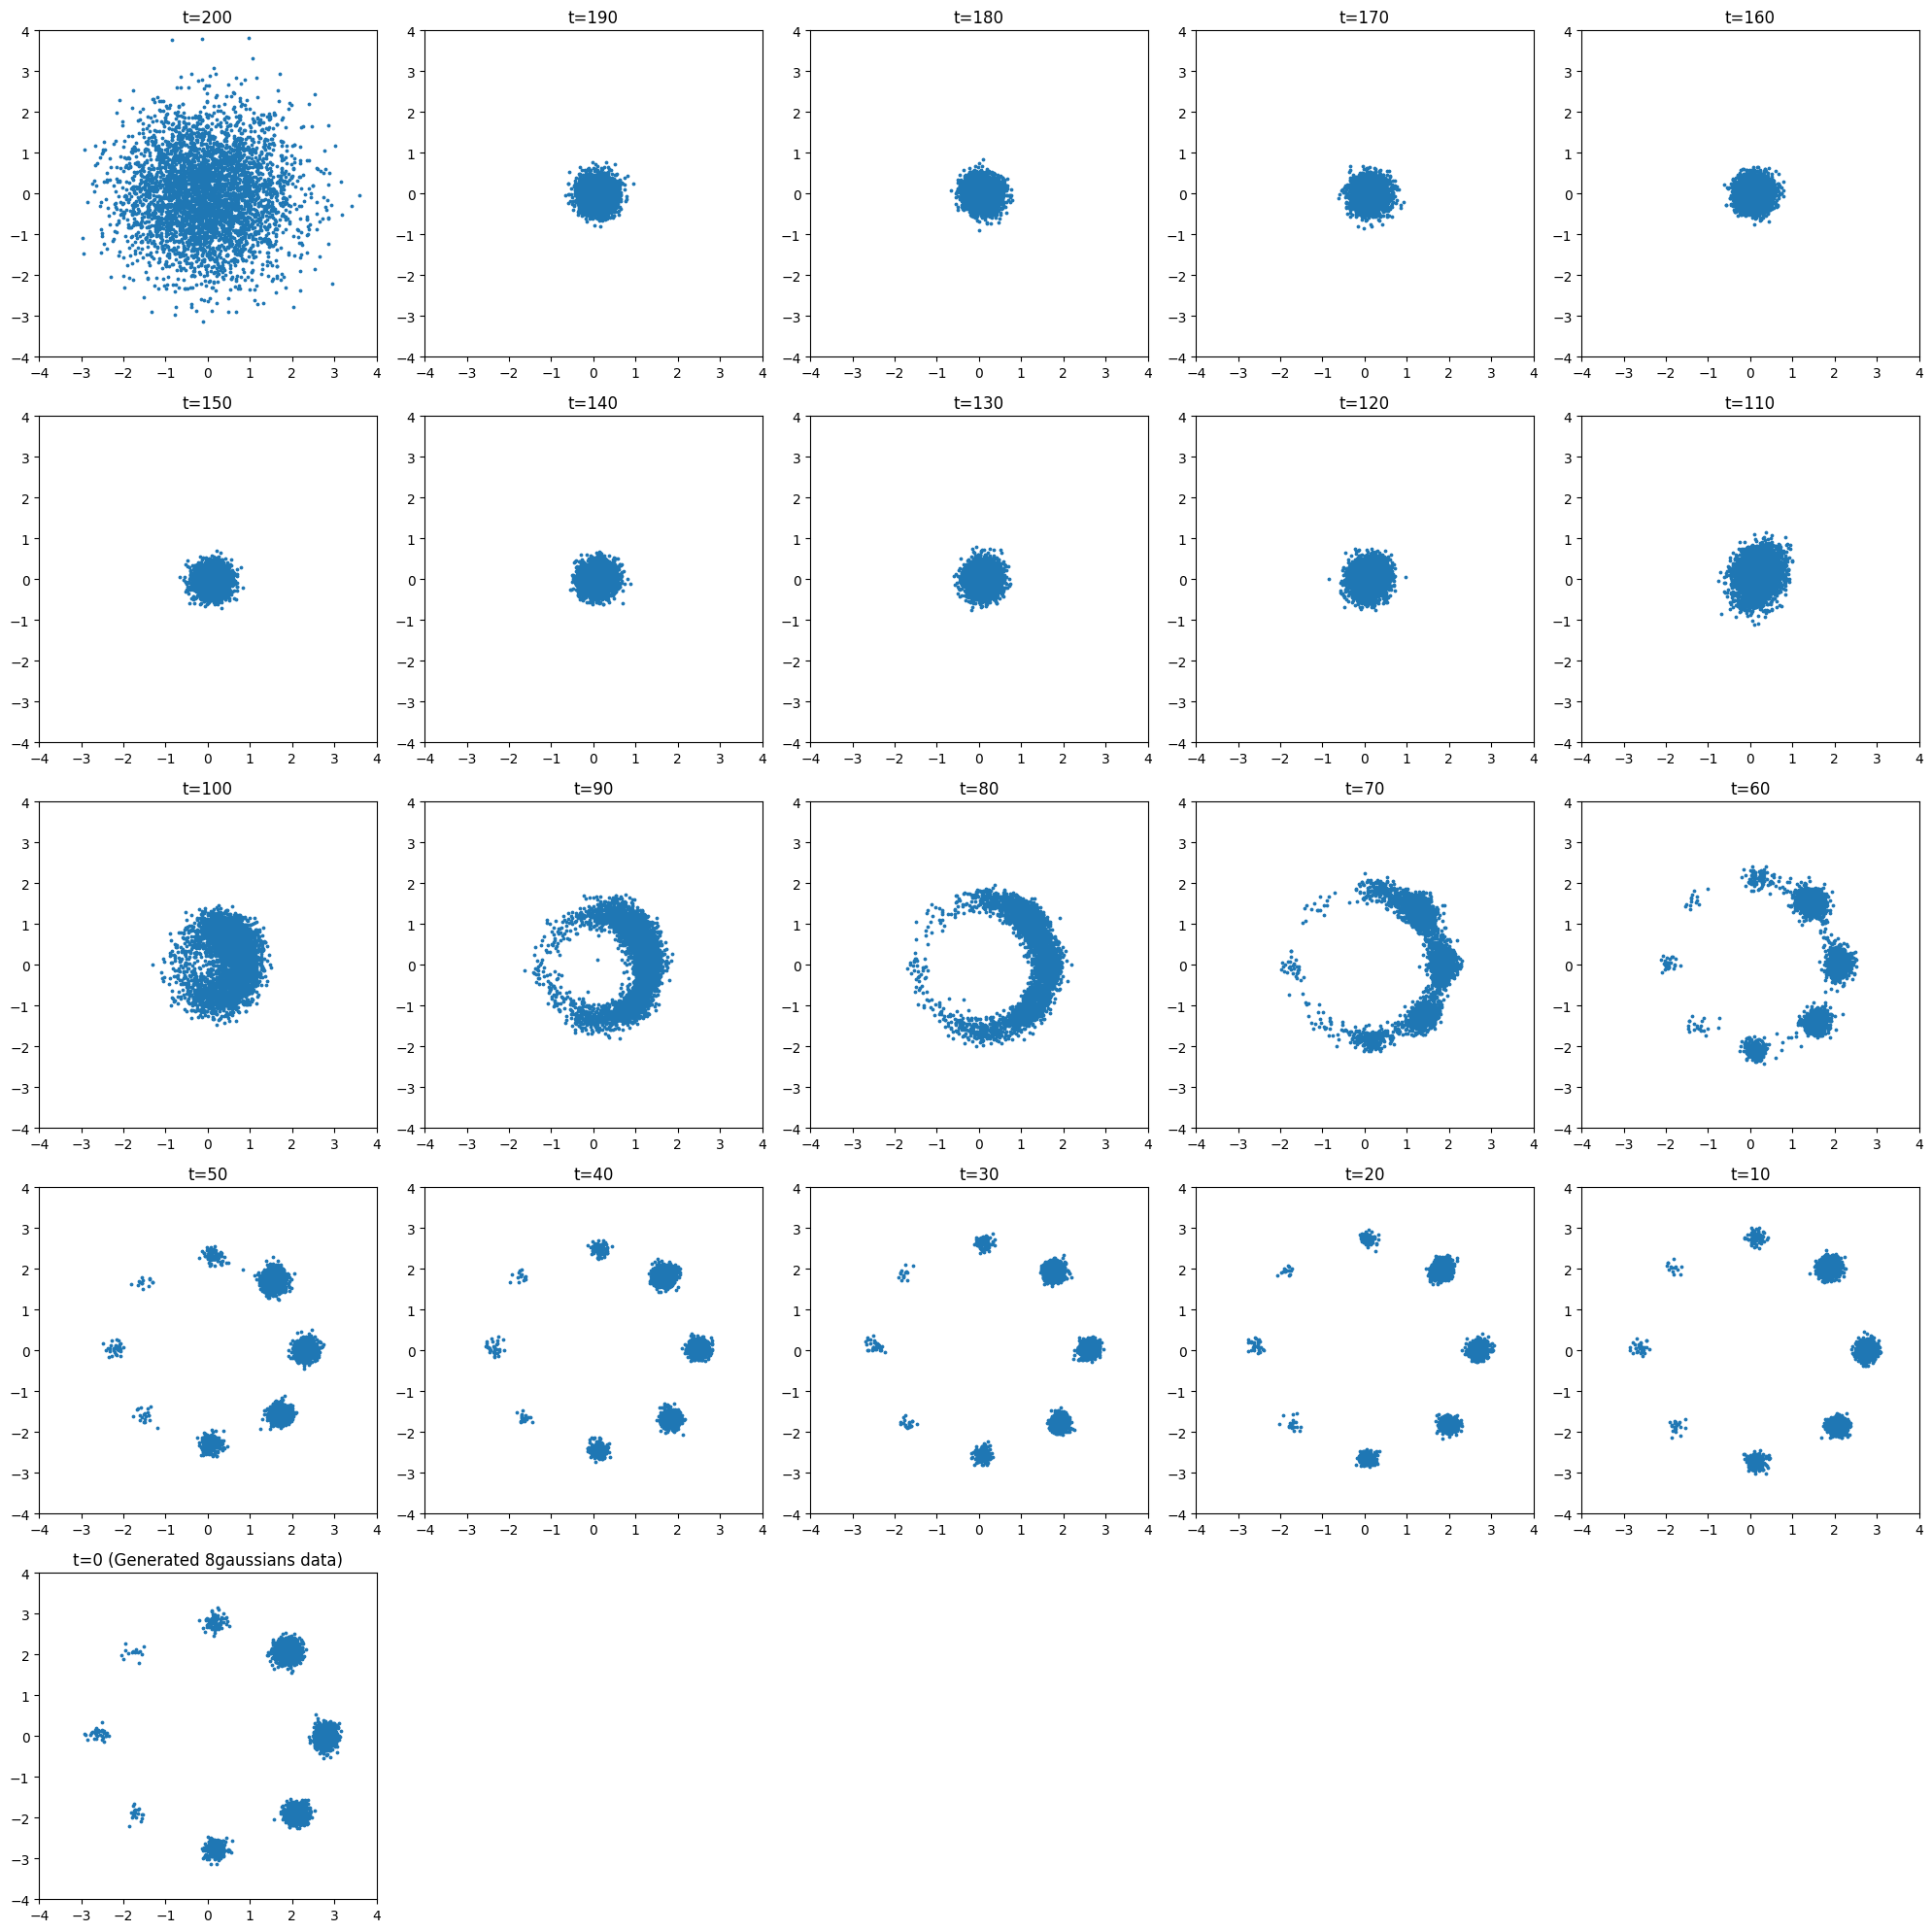

In [14]:
import math

n_plot = 20  # Number of plots for intermediate timesteps
n_total = n_plot + 1  # Total plots (including final sample)
n_cols = 5  # 5 plots per row
n_rows = math.ceil(n_total / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axs = axs.flatten()

for i in range(n_total):
    ax = axs[i]
    if i < n_plot:
        t = (n_step // n_plot) * i
        samples = samples_traj[t]
        ax.scatter(samples[:, 0], samples[:, 1], s=3)
        ax.set_title(f't={200 - t}')
    else:
        ax.scatter(final_sample[:, 0], final_sample[:, 1], s=3)
        ax.set_title('t=0 (Generated 8gaussians data)')
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

# Hide any unused subplots if they exist
for j in range(n_total, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


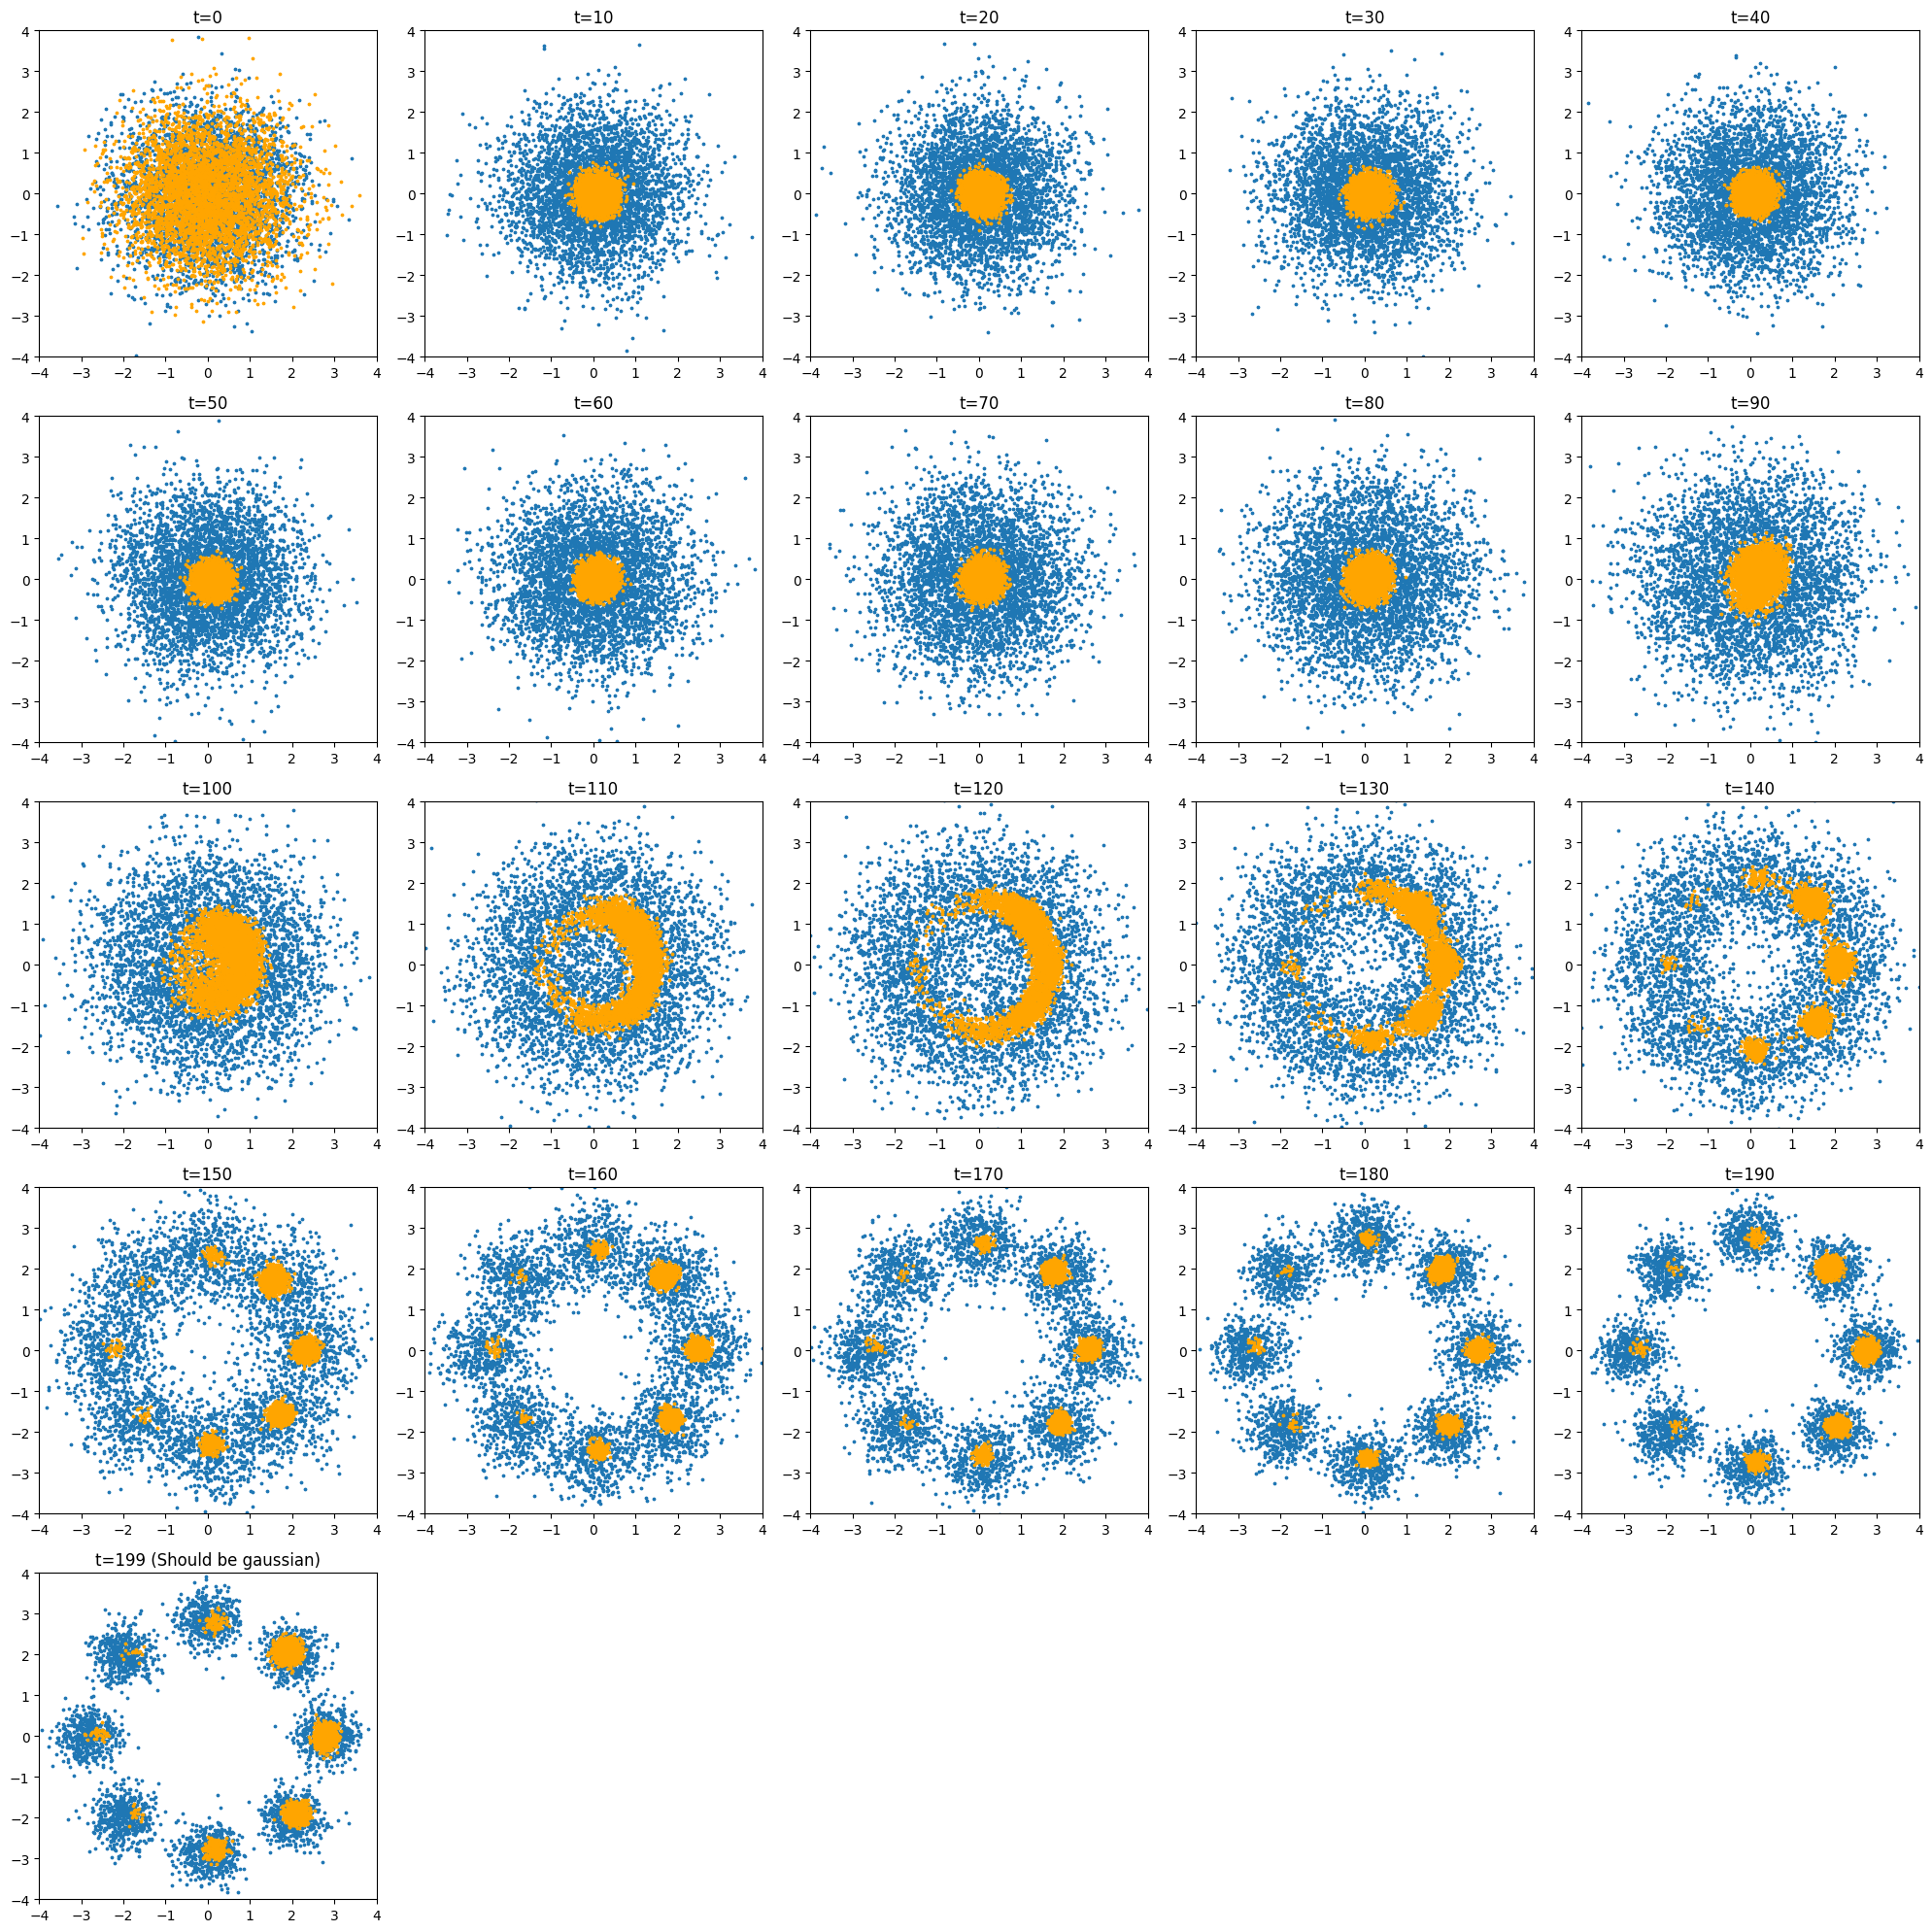

In [15]:
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axs = axs.flatten()

x = torch.tensor(sample2d(dataset_name, batch_size=4000)).to(device)

for i in range(n_total):
    ax = axs[i]
    if i < n_plot:
        t = (n_step // n_plot) * i  # t will be 0, 20, 40, ... up to 180 if n_step=200
        x_diffused = diffuse(x, n_step - t - 1).cpu()
        samples = samples_traj[t]
        ax.scatter(x_diffused[:, 0], x_diffused[:, 1], s=3, label="original")
        ax.scatter(samples[:, 0], samples[:, 1], s=3, color="orange", label="Generated")
        ax.set_title(f't={t}')
    else:
        t = n_step - 1  # 마지막은 t=199로 설정
        x_diffused = diffuse(x, n_step - t - 1).cpu()
        samples = samples_traj[t]
        ax.scatter(x_diffused[:, 0], x_diffused[:, 1], s=3, label="original")
        ax.scatter(samples[:, 0], samples[:, 1], s=3, color="orange", label="Generated")
        ax.set_title(f't={t} (Should be gaussian)')
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

# Hide any unused subplots if they exist
for j in range(n_total, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()
